<a href="https://colab.research.google.com/github/TIGGERKUB/ThaiToTSL/blob/main/SignLanguage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install sklearn_crfsuite
# !pip install https://github.com/PyThaiNLP/pythainlp/archive/dev.zip
# !pip install fastai==1.0.46
# !pip install attacut

In [ ]:
import numpy as np
from keras.models import Model, load_model
from keras.layers import Input, LSTM, Dense,Embedding
from keras.utils import *
from keras.initializers import *
from keras.optimizers import Adam
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import time, random
import pandas as pd
import re

In [ ]:
from pythainlp.tokenize import word_tokenize
from gensim.models import KeyedVectors
from pythainlp import word_vector
import numpy as np

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

import dill as pickle
import pandas as pd
model_path = 'thwiki_data/models/'
model = word_vector.get_model()


In [ ]:
BATCH_SIZE = 64
EPOCHS = 100
LSTM_NODES =256
MAX_SENTENCE_LENGTH = 50
EMBEDDING_SIZE = 300
MAX_NUM_WORDS = 100

In [ ]:
embeddings_dictionary = {}
for word in model.index2word:
    embeddings_dictionary[word] = model[word]

In [ ]:
def read_data(filename):
  df = pd.read_excel(filename)
  return df

In [ ]:
path = "/content/drive/MyDrive/Colab Notebooks/tsl/train_data.xlsx"
df = read_data(path)

In [ ]:
pairs = list(zip(df['th tokenized'],df['tsl tokenized']))
random.shuffle(pairs)

In [ ]:
input_sentences = []
output_sentences = []
output_sentences_inputs = []

for ele in pairs:
  input_sentence, output = ele[0], ele[1]
  output_sentence = output + ' <eos>'
  output_sentence_input = '<sos> ' + output

  input_sentences.append(input_sentence)
  output_sentences.append(output_sentence)
  output_sentences_inputs.append(output_sentence_input)

In [ ]:
print(input_sentences[50])
print(output_sentences[50])
print(output_sentences_inputs[50])

พี่ ขับ รถ ไป ทำงาน
ทำงาน รถ ไป พี่ ขับ <eos>
<sos> ทำงาน รถ ไป พี่ ขับ


# Unique word

In [ ]:
from keras.preprocessing.text import Tokenizer
input_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

word2idx_inputs = input_tokenizer.word_index
print('Total unique words in the input: %s' % len(word2idx_inputs))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Length of longest sentence in input: %g" % max_input_len)

Total unique words in the input: 216
Length of longest sentence in input: 7


In [ ]:
output_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS,filters='')
output_tokenizer.fit_on_texts(output_sentences + output_sentences_inputs)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

word2idx_outputs = output_tokenizer.word_index
print('Total unique words in the output: %s' % len(word2idx_outputs))

num_words_output = len(word2idx_outputs) + 1
max_out_len = max(len(sen) for sen in output_integer_seq)
print("Length of longest sentence in the output: %g" % max_out_len)

Total unique words in the output: 214
Length of longest sentence in the output: 8


In [ ]:
print(len(word2idx_inputs))
print(len(word2idx_outputs))

216
214


# Padding
The reason behind padding the input and the output is that text sentences can be of varying length, however LSTM (the algorithm that we are going to train our model) expects input instances with the same length. Therefore, we need to convert our sentences into fixed-length vectors. One way to do this is via padding.

In [ ]:
encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
decoder_output_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("encoder_input_sequences.shape:", encoder_input_sequences.shape)
print("decoder_output_sequences.shape:", decoder_output_sequences.shape)

encoder_input_sequences.shape: (99, 7)
decoder_output_sequences.shape: (99, 8)


# Word Embeddings

In [ ]:
num_words = len(word2idx_inputs) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_SIZE))
for word, index in word2idx_inputs.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
embedding_layer = Embedding(num_words, EMBEDDING_SIZE, weights=[embedding_matrix], input_length=max_input_len)

# Creating the model

In [ ]:
decoder_targets_one_hot = np.zeros((
        len(input_sentences),
        max_out_len,
        num_words_output
    ),
    dtype='float32'
)

In [ ]:
decoder_targets_one_hot.shape

(99, 8, 215)

In [ ]:
for i, d in enumerate(decoder_output_sequences):
    for t, word in enumerate(d):
        decoder_targets_one_hot[i, t, word] = 1

**Encoder**

In [ ]:
encoder_inputs_placeholder = Input(shape=(max_input_len,))
x = embedding_layer(encoder_inputs_placeholder)
encoder = LSTM(LSTM_NODES, return_state=True)

encoder_outputs, h, c = encoder(x)
encoder_states = [h, c]

**Decoder**

In [ ]:
decoder_inputs_placeholder = Input(shape=(max_out_len,))

decoder_embedding = Embedding(num_words_output, LSTM_NODES)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)

decoder_lstm = LSTM(LSTM_NODES, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

In [ ]:
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [ ]:
model = Model([encoder_inputs_placeholder,
  decoder_inputs_placeholder], decoder_outputs)
model.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

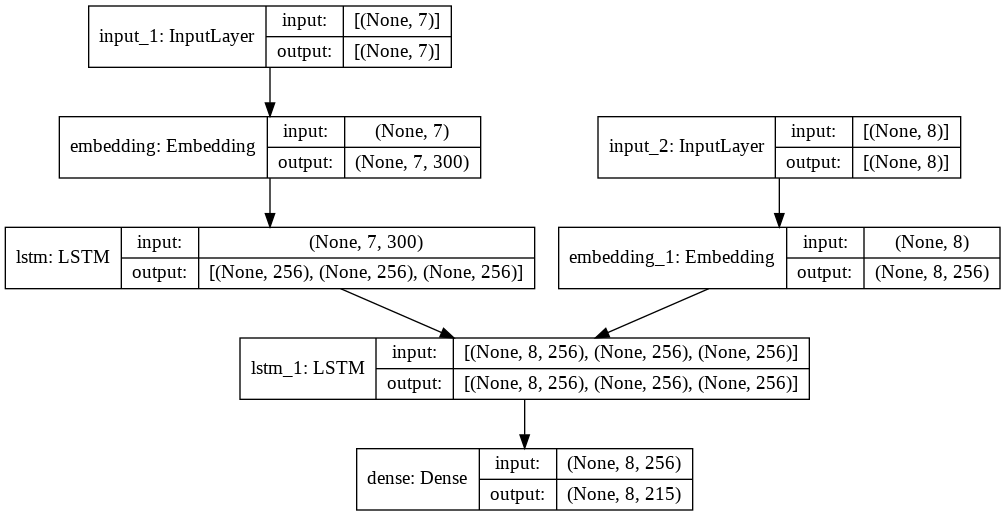

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

In [ ]:
model.fit(
    [encoder_input_sequences, decoder_output_sequences],
    decoder_targets_one_hot,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.2,
)
model.save("training_model.h5")

# Modifying the Model for Predictions

In [ ]:
encoder_model = Model(encoder_inputs_placeholder, encoder_states)

**Decoder hidden and cell states**

In [ ]:
decoder_state_input_h = Input(shape=(LSTM_NODES,))
decoder_state_input_c = Input(shape=(LSTM_NODES,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

In [ ]:
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

In [ ]:
decoder_outputs, h, c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)

In [ ]:
decoder_states = [h, c]
decoder_outputs = decoder_dense(decoder_outputs)

In [ ]:
decoder_model = Model(
    [decoder_inputs_single] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)

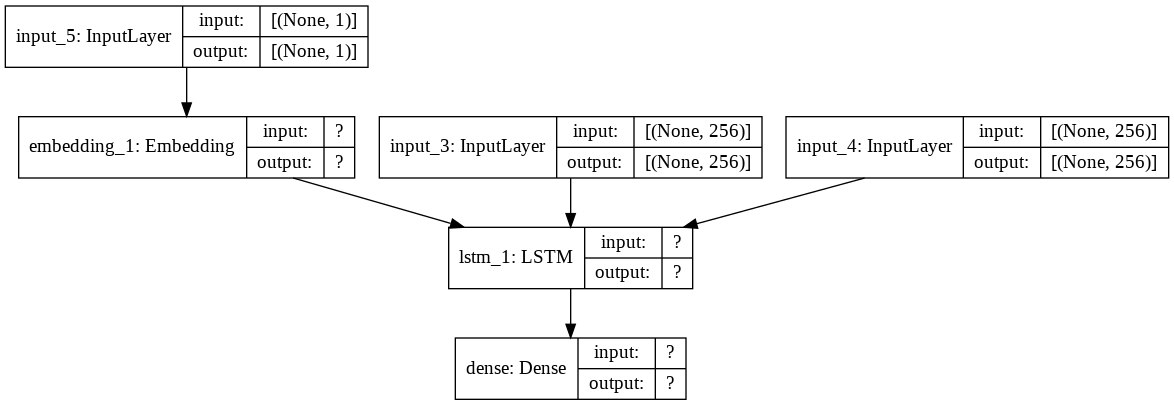

In [ ]:
from keras.utils import plot_model
plot_model(decoder_model, to_file='model_plot_dec.png', show_shapes=True, show_layer_names=True)

In [ ]:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [ ]:
def translate_sentence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']
    eos = word2idx_outputs['<eos>']
    output_sentence = []

    for _ in range(max_out_len):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        if eos == idx:
            break

        word = ''

        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        target_seq[0, 0] = idx
        states_value = [h, c]

    return ' '.join(output_sentence)

In [ ]:
import attacut
from keras.preprocessing.text import Tokenizer

def string_to_matrix(user_input):
    atta = attacut.Tokenizer(model="attacut-sc")
    words = attacut.tokenize(user_input)
    tokens = [words]

    user_input_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
    user_input_tokenizer.fit_on_texts(tokens)
    user_input_integer_seq = user_input_tokenizer.texts_to_sequences(tokens)

    user_encoder_input_sequences = pad_sequences(user_input_integer_seq, maxlen=max_input_len)
    return user_encoder_input_sequences

In [ ]:
input_text = input("Input: \n")
input_seq = string_to_matrix(input_text)
print(input_seq)
translation = translate_sentence(input_seq)
print("response: ",translation)

Input: 
ฉันติดต่อคนขาย
[[0 0 0 1 2 3 4]]
response:  <sos> <sos> ใน ใน ใน ใน ใน ใน


In [ ]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
print(input_seq)
translation = translate_sentence(input_seq)
print('-')
print('Input:', input_sentences[i])
print('Response:', translation)

[[ 1 55 56 57 19 12 58]]
-
Input: ฉัน ติดต่อ คนขาย ทันที ที่ ของ มาถึง
Response: <sos> คนขาย คนขาย ติดต่อ ทันที ทันที ของ มาถึง


In [ ]:
# def decode_response(test_input):
#     print(test_input.shape)
#     #Getting the output states to pass into the decoder
#     states_value = encoder_model.predict(test_input)

#     #Generating empty target sequence of length 1
#     target_seq = np.zeros((1, 1, num_decoder_tokens))

#     #Setting the first token of target sequence with the start token
#     target_seq[0, 0, word2idx_outputs['<sos>']] = 1.
    
#     #A variable to store our response word by word
#     decoded_sentence = ''
    
#     stop_condition = False
#     while not stop_condition:
#       #Predicting output tokens with probabilities and states
#       output_tokens, hidden_state, cell_state = decoder_model.predict([target_seq] + states_value)

#       #Choosing the one with highest probability
#       sampled_token_index = np.argmax(output_tokens[0, -1, :])
#       sampled_token = idx2word_target[sampled_token_index]
#       decoded_sentence += " " + sampled_token

#       #Stop if hit max length or found the stop token
#       if (sampled_token == '<eos>' or len(decoded_sentence) > max_out_len):
#         stop_condition = True

#       #Update the target sequence
#       target_seq = np.zeros((1, 1, len(word2idx_outputs)))
#       target_seq[0, 0, sampled_token_index] = 1.

#       #Update states
#       states_value = [hidden_state, cell_state]
#     return decoded_sentence

In [ ]:
# from attacut import tokenize, Tokenizer

# class Translator:
#   exit_commands = ("quit","exit")
  
#   #Method to start the translator
#   def start(self):
#     user_response = input("Give in an sentence. :) \n")
#     self.translate(user_response)
  
#   #Method to handle the conversation
#   def translate(self, reply):
#     while not self.make_exit(reply):
#       reply = input(self.generate_response(reply)+"\n")

#   #Method to convert user input into a matrix
#   def string_to_matrix(self, user_input):
#     atta = Tokenizer(model="attacut-sc")
#     words = atta.tokenize(user_input)
#     tokens = words
#     user_input_matrix = np.zeros((1, max_input_len, len(word2idx_inputs)),dtype='float32')
#     for timestep, token in enumerate(tokens):
#       if token in word2idx_inputs:
#         user_input_matrix[0, timestep, word2idx_inputs[token]] = 1.
#     return user_input_matrix
  
#   #Method that will create a response using seq2seq model we built
#   def generate_response(self, user_input):
#     input_matrix = self.string_to_matrix(user_input)
#     chatbot_response = decode_response(input_matrix)
#     #Remove <sos> and <eos> tokens from chatbot_response
#     chatbot_response = chatbot_response.replace("<sos>",'')
#     chatbot_response = chatbot_response.replace("<eos>",'')
#     return chatbot_response
  
#   #Method to check for exit commands
#   def make_exit(self, reply):
#     for exit_command in self.exit_commands:
#       if exit_command in reply:
#         print("Ok, have a great day!")
#         return True
#     return False
  
# translator = Translator()